In [1]:
import os
import numpy as np
from functools import partial
import math
import time as time

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="2"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib.ticker as tick

import scipy as sp
import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg


True
1
0
NVIDIA A100-PCIE-40GB
Using device: cuda


In [2]:
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'

# save_dir = '/disk/xray0/tl3/outputs/large-scale-UQ/def_UQ_results/CRR/hypothesis_test_paper_figs/'
# load_var_dir = '/disk/xray0/tl3/outputs/large-scale-UQ/def_UQ_results/CRR/vars/'

save_dir = '/disk/xray0/tl3/outputs/large-scale-UQ/def_UQ_results/v2/CRR/hypothesis_test_paper_figs/'
load_var_dir = '/disk/xray99/tl3/proj-convex-UQ/outputs/new_UQ_results/CRR/vars/'

# Confidence value
alpha_prob = 0.01
# Blurring Gaussian St Dev
G_sigma = 3.5 # 2 # 1.02

# Inpatinting params
inptaint_options = {
    "tol": 5e-6,
    "iter": 15000,
    "update_iter": 4999,
    "record_iters": False
}

mmse_potential_list = []
surrogate_potential_list = []
gamma_alpha_list = []
gamma_alpha_samples_list = []
Hnot_reject_list = []
potential_blurring_list = []
Hnot_reject_blurring_list = []

cmap = 'cubehelix'
model_prefix = '-CRR'
cbar_font_size = 18

# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = '/disk/xray0/tl3/repos/convex_ridge_regularizers/trained_models/'
# CRR parameters
# reg_params = [5e4]
lmbd = 5e4
mu = 20

map_vars_path_arr = [
    load_var_dir+'CYN_CRR_UQ_MAP_lmbd_5.0e+04_MAP_vars.npy',
    load_var_dir+'M31_CRR_UQ_MAP_lmbd_5.0e+04_MAP_vars.npy',
    load_var_dir+'3c288_CRR_UQ_MAP_lmbd_5.0e+04_MAP_vars.npy',
    load_var_dir+'3c288_CRR_UQ_MAP_lmbd_5.0e+04_MAP_vars.npy',
    load_var_dir+'W28_CRR_UQ_MAP_lmbd_5.0e+04_MAP_vars.npy',
]
samp_vars_path_arr = [
    load_var_dir+'CYN_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',
    load_var_dir+'M31_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',
    load_var_dir+'3c288_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',
    load_var_dir+'3c288_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',
    load_var_dir+'W28_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',    
]
samp_samples_path_arr = [
    load_var_dir+'CYN_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_samples.npy',
    load_var_dir+'M31_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_samples.npy',
    load_var_dir+'3c288_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_samples.npy',
    load_var_dir+'3c288_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_samples.npy',
    load_var_dir+'W28_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_samples.npy',      
]

input_snr = 30.
img_name_list = ['CYN', 'M31', '3c288', '3c288','W28']
pysiscal_list = [True, True, True, False, True]
vmin_log_arr = [-3., -2., -2., -2., -2.]
text_str_arr = [r'$1$',r'$1$',r'$1$',r'$2$',r'$1$']
saving_text_str_arr = ['1', '1', '1', '2', '1']
text_pos_arr = [
    [0, 0.08],
    [0, 0.04],
    [0, 0.04],
    [0, 0.04],
    [0, 0.04],
]


# Load CRR model
torch.set_grad_enabled(False)
torch.set_num_threads(4)

exp_name = f'Sigma_{sigma_training}_t_{t_model}/'
model = utils_cvx_reg.load_model(CRR_dir_name + exp_name, 'cuda:0', device_type='gpu')

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

# L_CRR = model.L.detach().cpu().squeeze().numpy()
# print(f"Lipschitz bound {L_CRR:.3f}")

# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183
Lipschitz bound 0.770


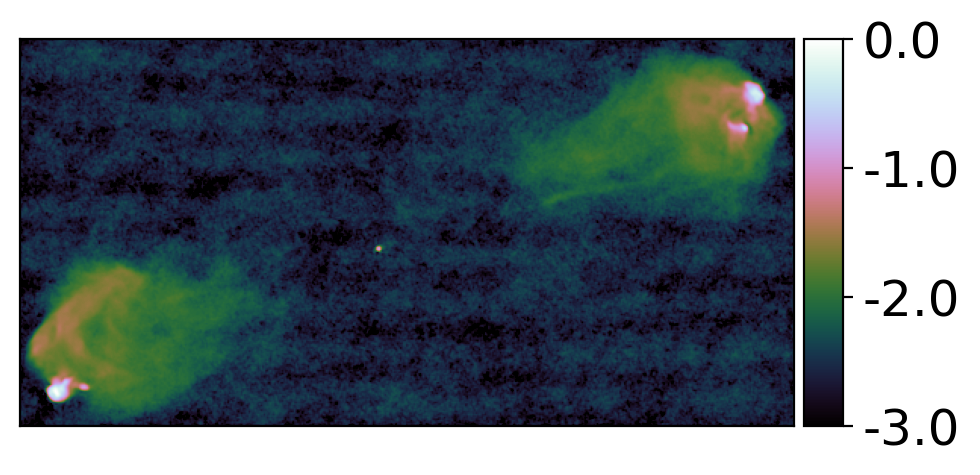

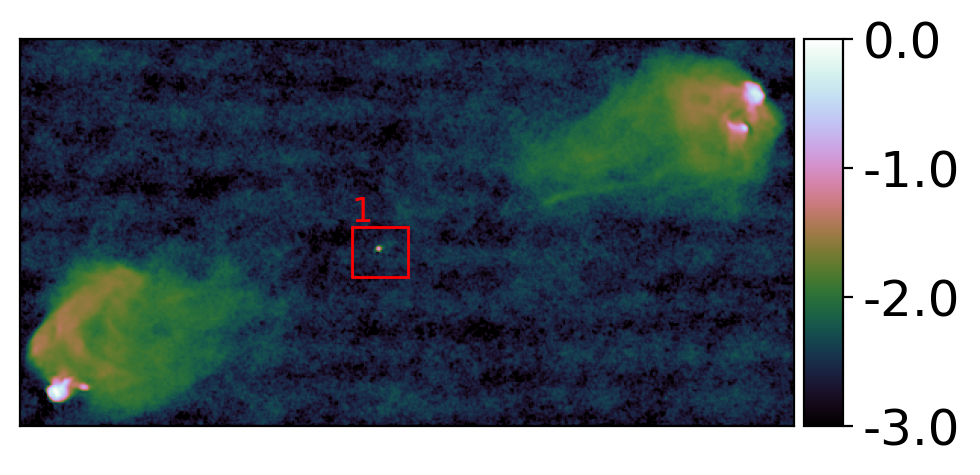

[GD] 0 out of 15000 iterations, tol = 0.000149
[GD] converged in 222 iterations


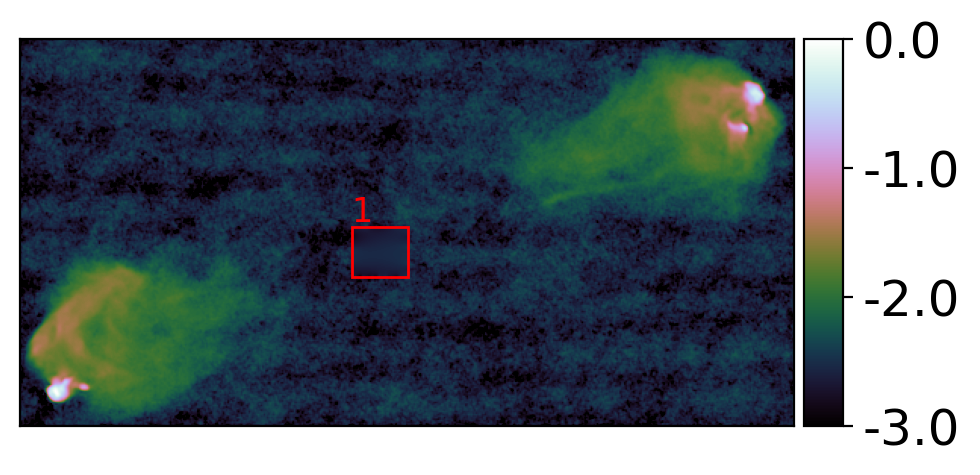

-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------
gamma_alpha:  145029.31792173782
fun(x_mmse).item():  12532.802734375
tau_alpha*np.sqrt(N) + N:  134530.56889830032
CYN _gamma_alpha(samples):  84771.47109375
CYN : Inpainted area removable! (Cannot reject H0)
CYN _gamma_alpha:  145029.31792173782
CYN _potential:  18197.3984375
CYN -MMSE_potential:  12532.802734375
CYN : Blurred structure is physical! (Reject H0)
CYN _gamma_alpha:  145029.31792173782
CYN _potential_blurring:  964157.875
CYN -MMSE_potential:  12532.802734375


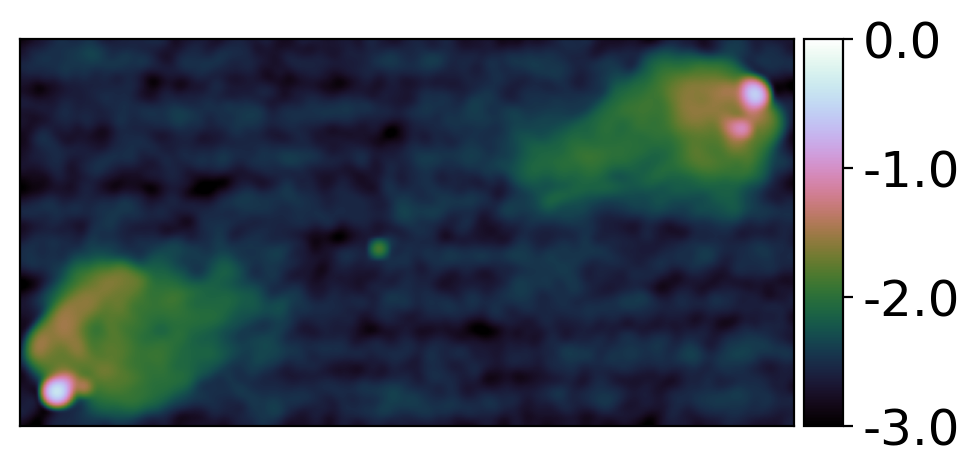

INSTRUME                                                                         [astropy.io.fits.card]


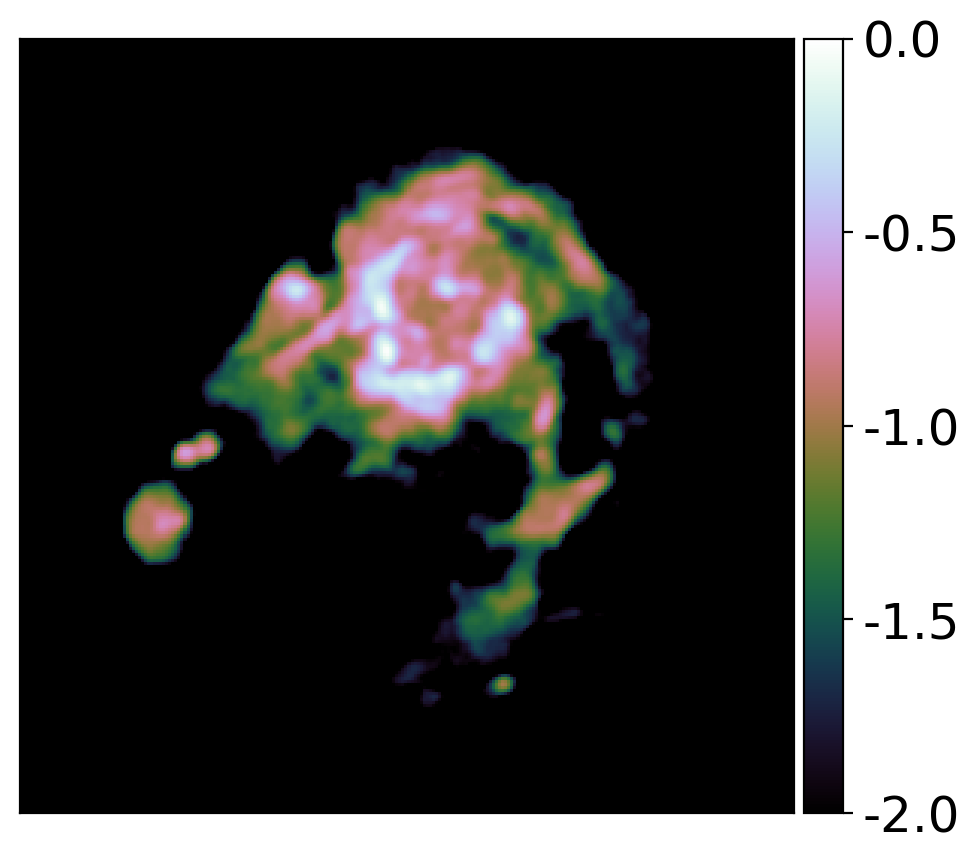

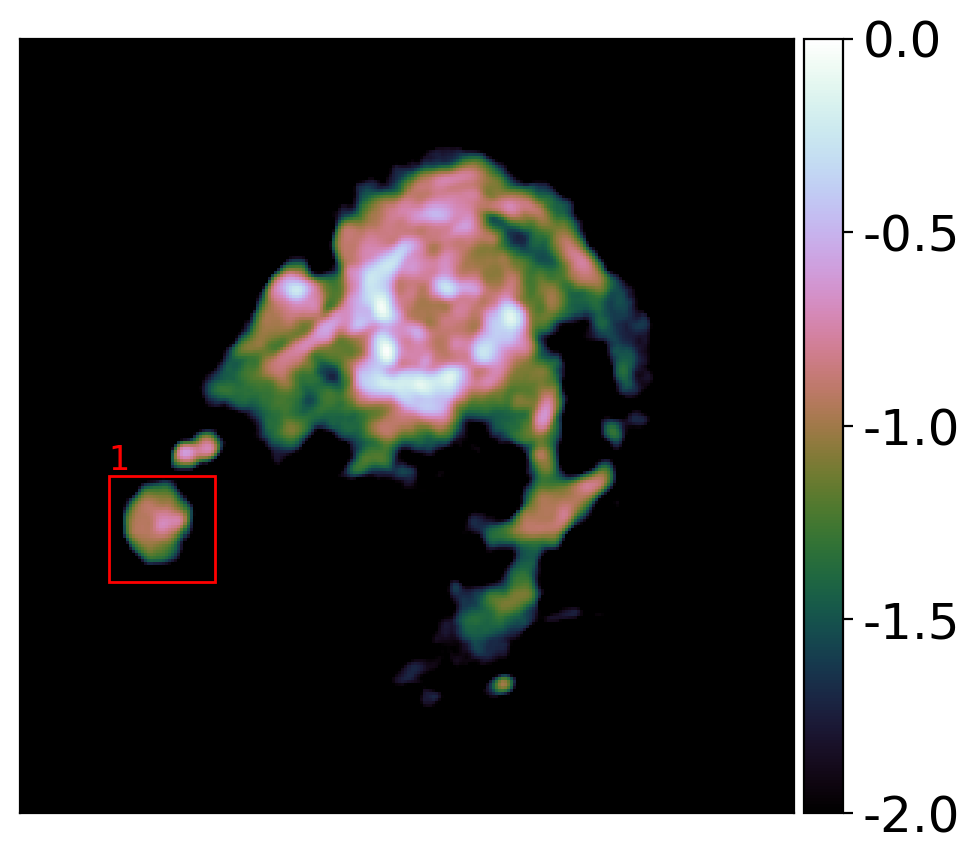

[GD] 0 out of 15000 iterations, tol = 0.000081
[GD] converged in 75 iterations


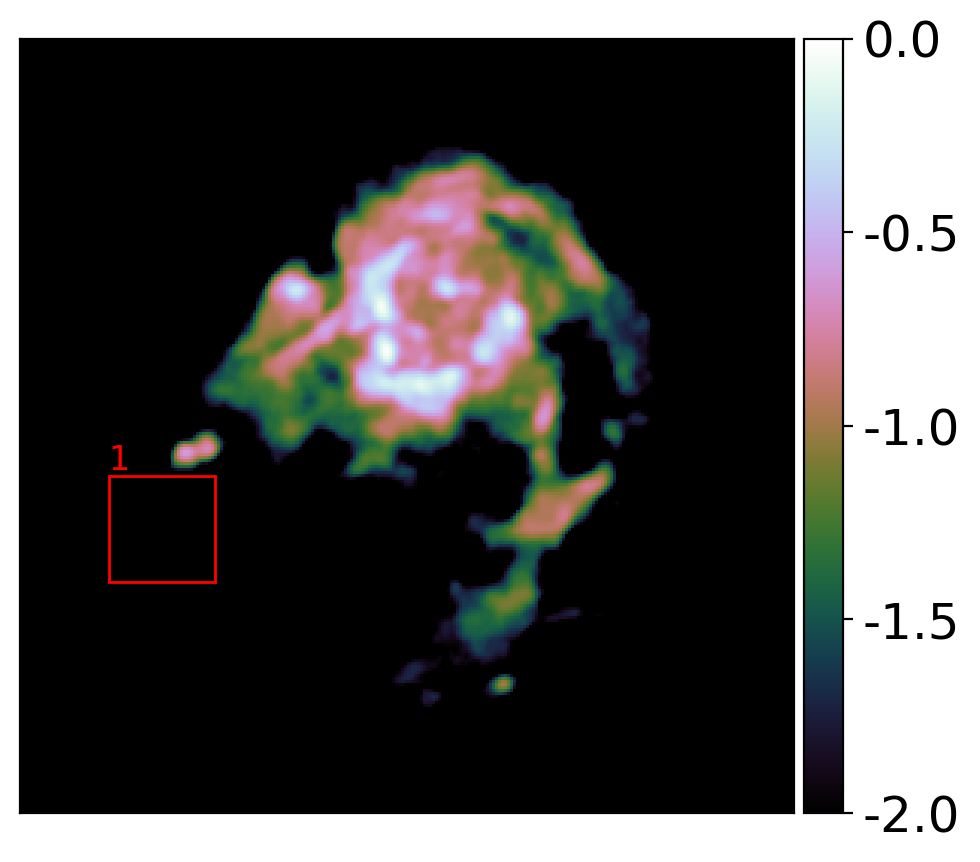

gamma_alpha:  98991.88416181403
fun(x_mmse).item():  33950.5234375
tau_alpha*np.sqrt(N) + N:  67981.57752118903
M31 _gamma_alpha(samples):  74248.54484375
M31 : Inpainted area removable! (Cannot reject H0)
M31 _gamma_alpha:  98991.88416181403
M31 _potential:  67508.203125
M31 -MMSE_potential:  33950.5234375
M31 : Blurred structure is physical! (Reject H0)
M31 _gamma_alpha:  98991.88416181403
M31 _potential_blurring:  190539.984375
M31 -MMSE_potential:  33950.5234375


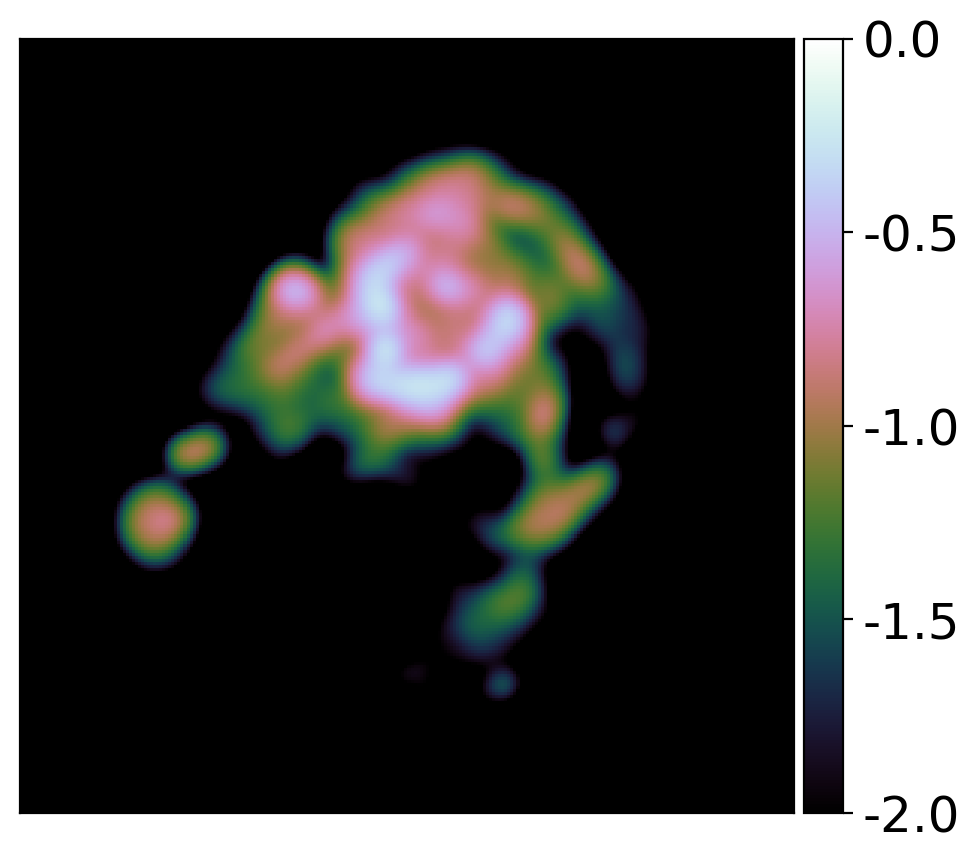

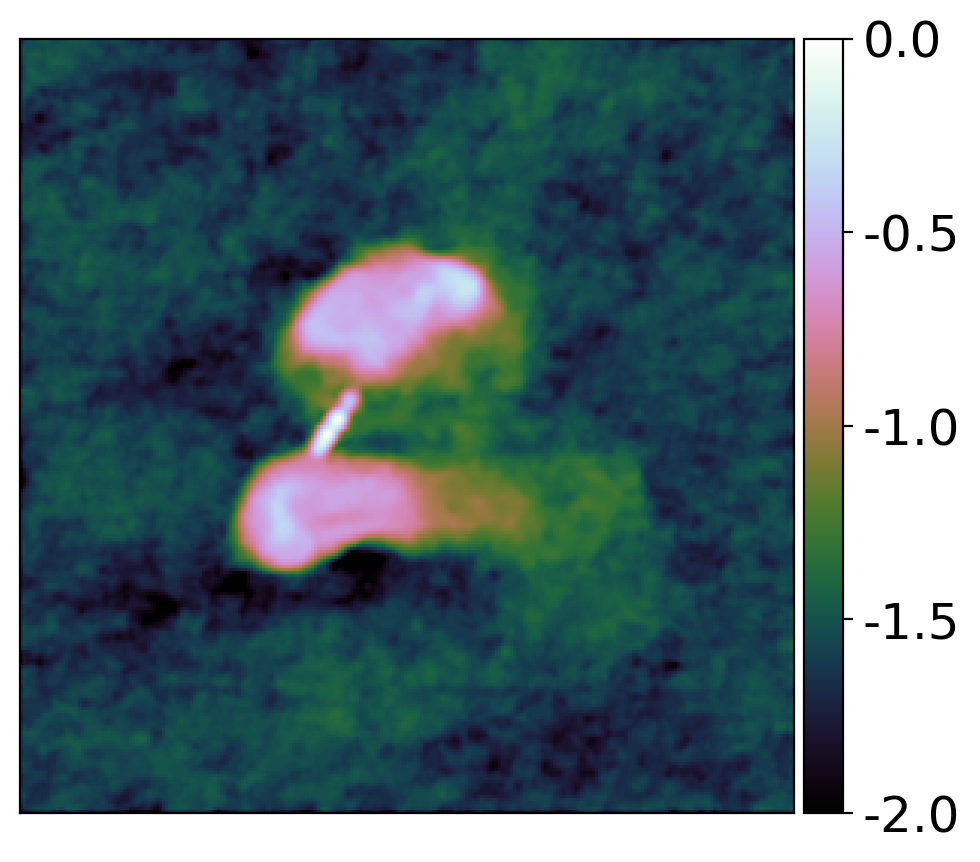

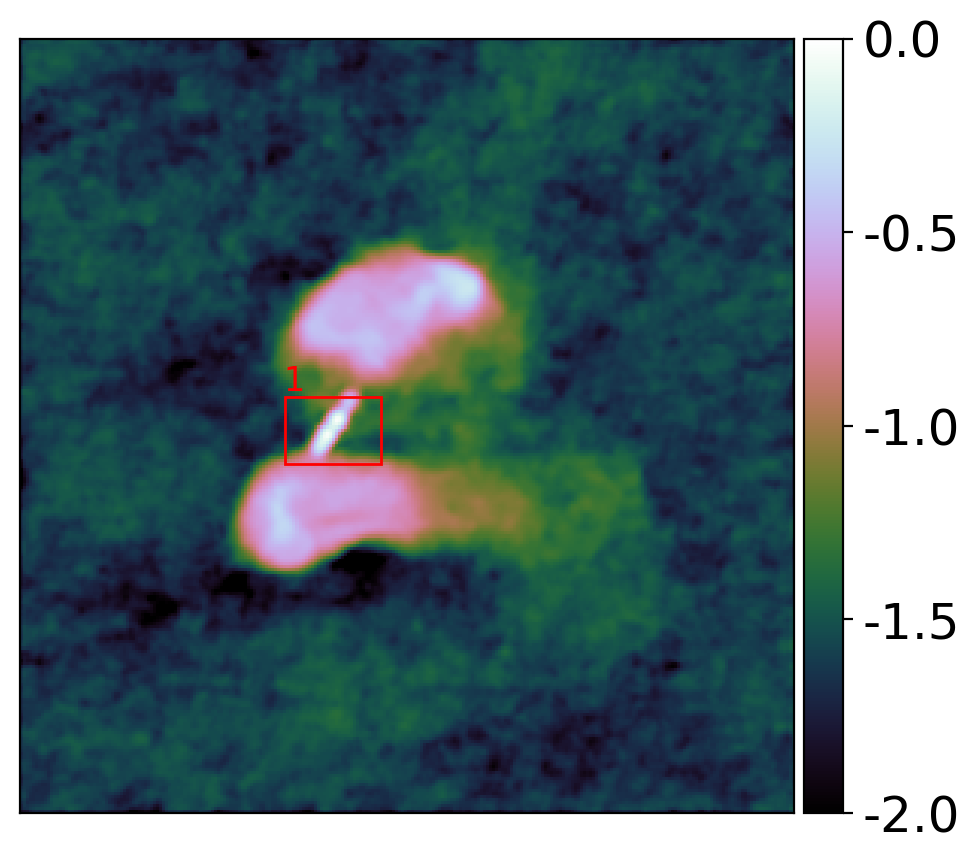

[GD] 0 out of 15000 iterations, tol = 0.000130
[GD] converged in 1161 iterations


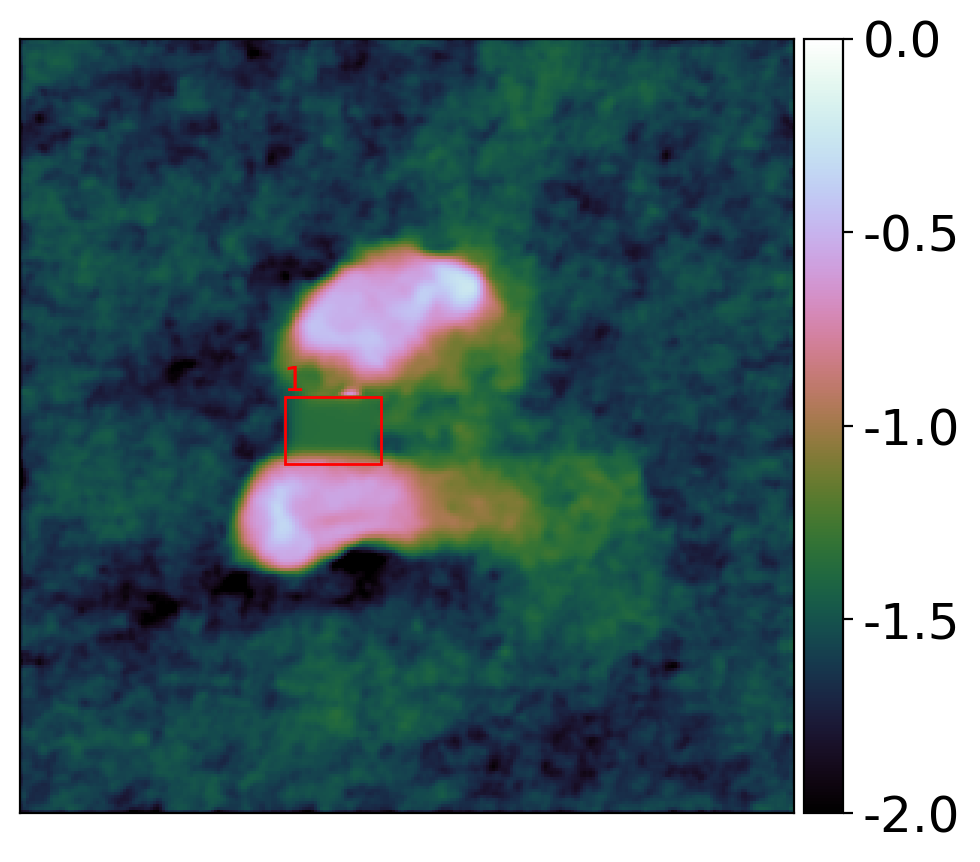

gamma_alpha:  90839.30017743903
fun(x_mmse).item():  25658.501953125
tau_alpha*np.sqrt(N) + N:  67981.57752118903
3c288 _gamma_alpha(samples):  65872.4159375
3c288 : Inpainted area nonremovable! (Reject H0)
3c288 _gamma_alpha:  90839.30017743903
3c288 _potential:  191765.96875
3c288 -MMSE_potential:  25658.501953125
3c288 : Blurred structure is physical! (Reject H0)
3c288 _gamma_alpha:  90839.30017743903
3c288 _potential_blurring:  92047.96875
3c288 -MMSE_potential:  25658.501953125


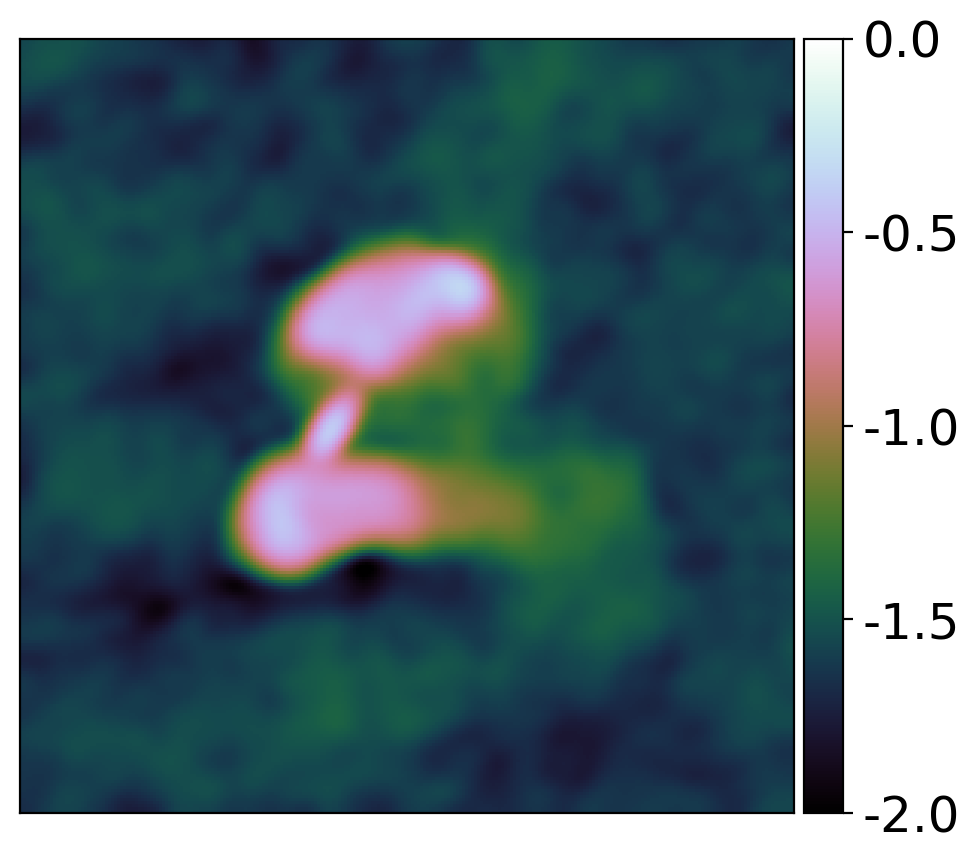

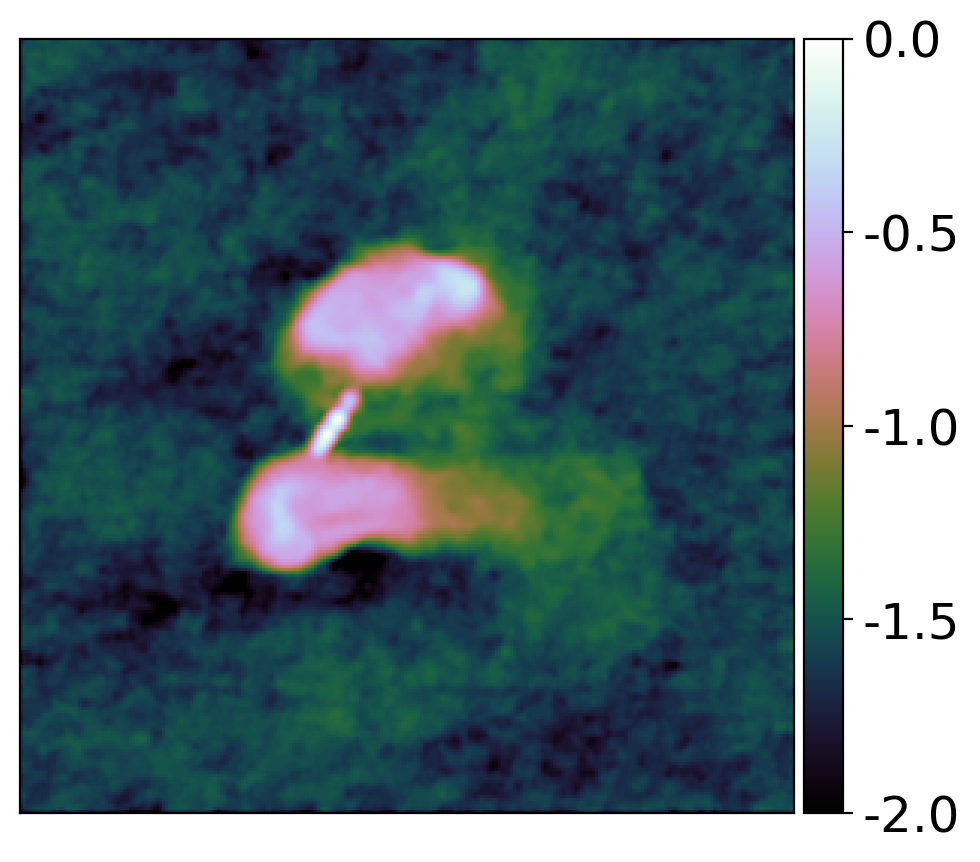

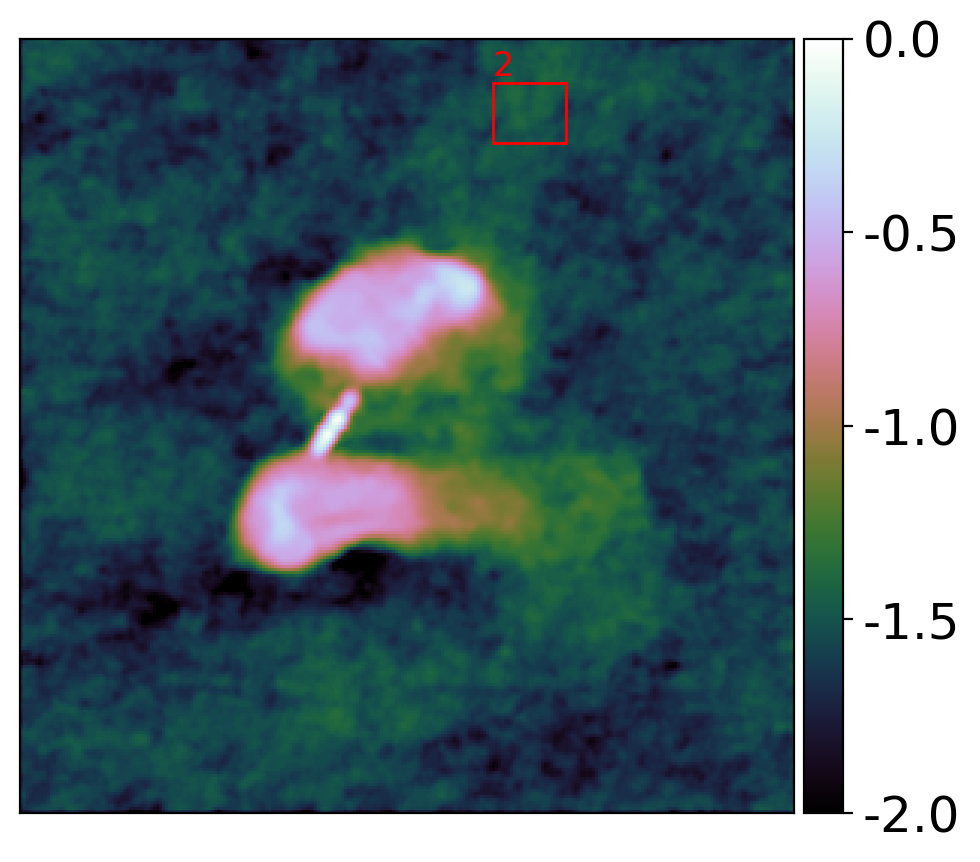

[GD] 0 out of 15000 iterations, tol = 0.000108
[GD] converged in 447 iterations


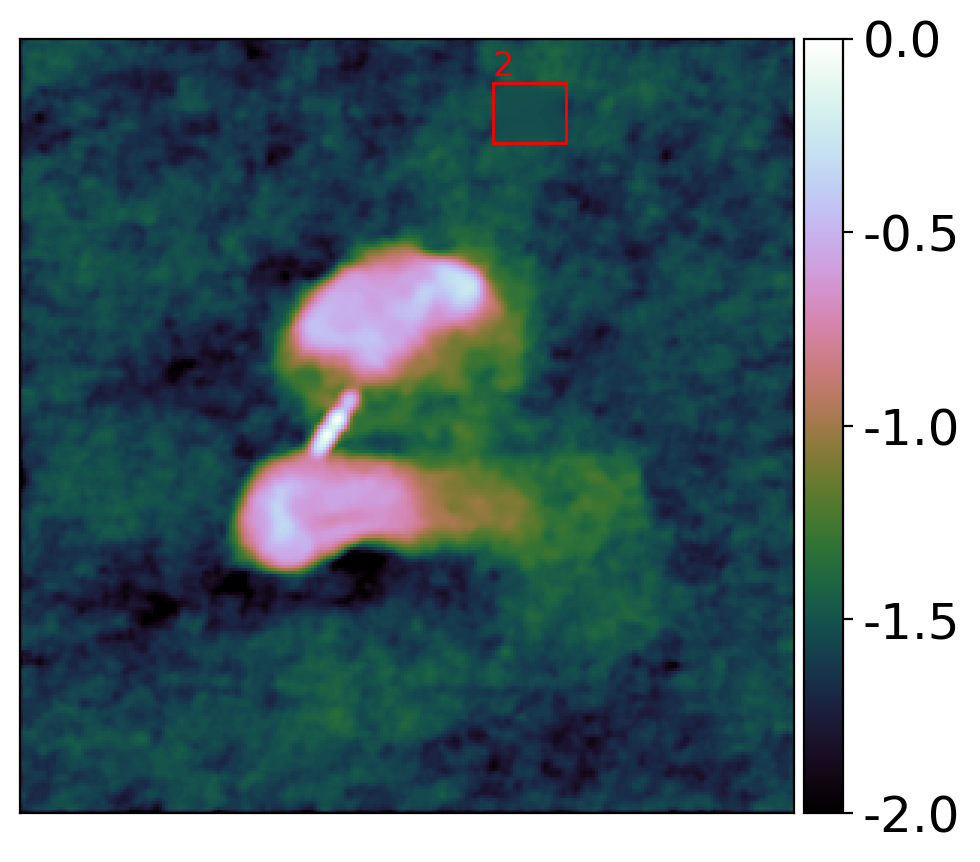

gamma_alpha:  90839.30017743903
fun(x_mmse).item():  25658.501953125
tau_alpha*np.sqrt(N) + N:  67981.57752118903
3c288 _gamma_alpha(samples):  65872.4159375
3c288 : Inpainted area removable! (Cannot reject H0)
3c288 _gamma_alpha:  90839.30017743903
3c288 _potential:  25702.982421875
3c288 -MMSE_potential:  25658.501953125
3c288 : Blurred structure is physical! (Reject H0)
3c288 _gamma_alpha:  90839.30017743903
3c288 _potential_blurring:  92047.96875
3c288 -MMSE_potential:  25658.501953125


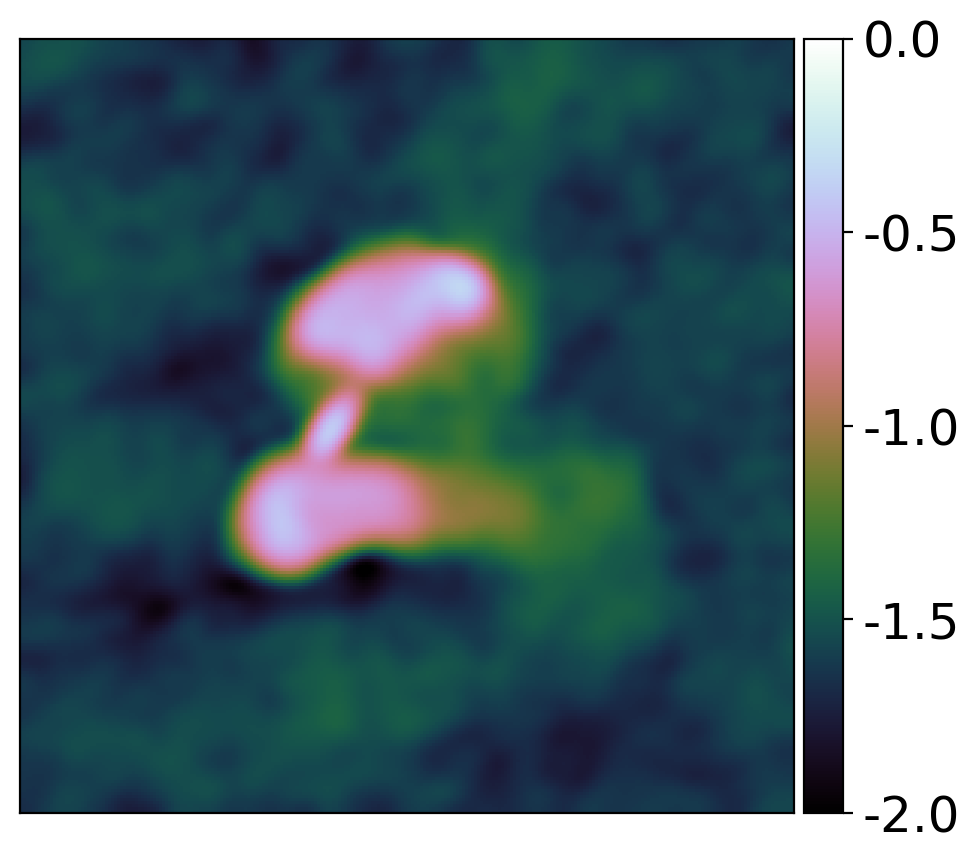

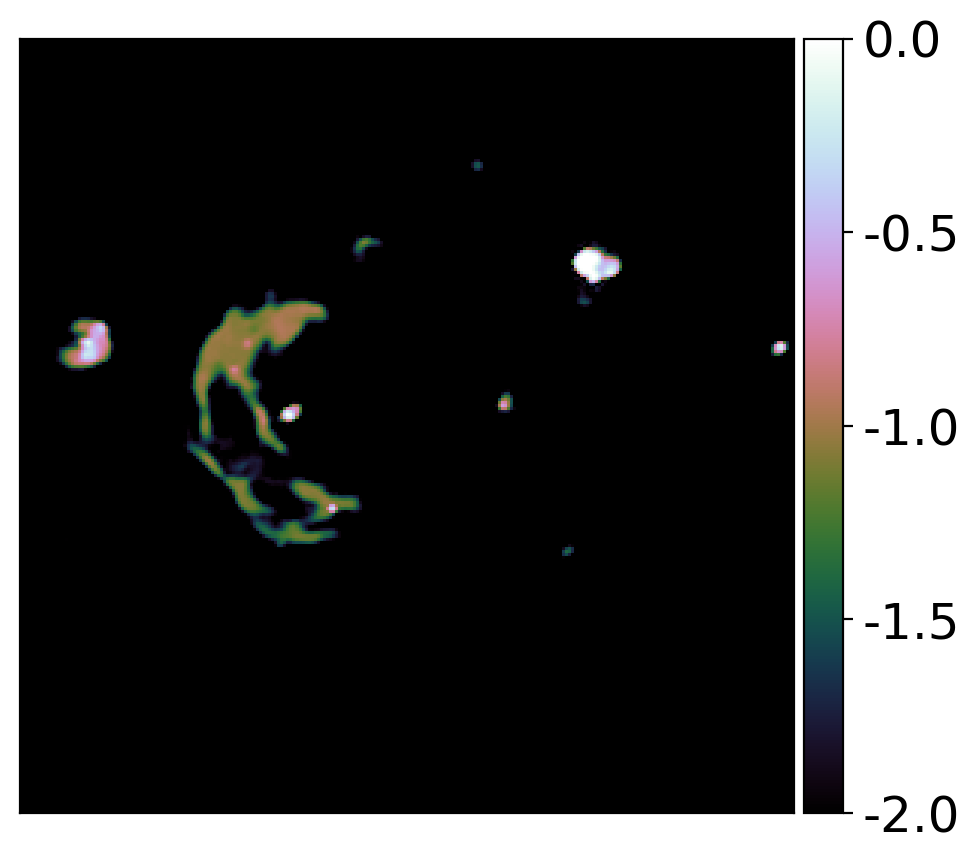

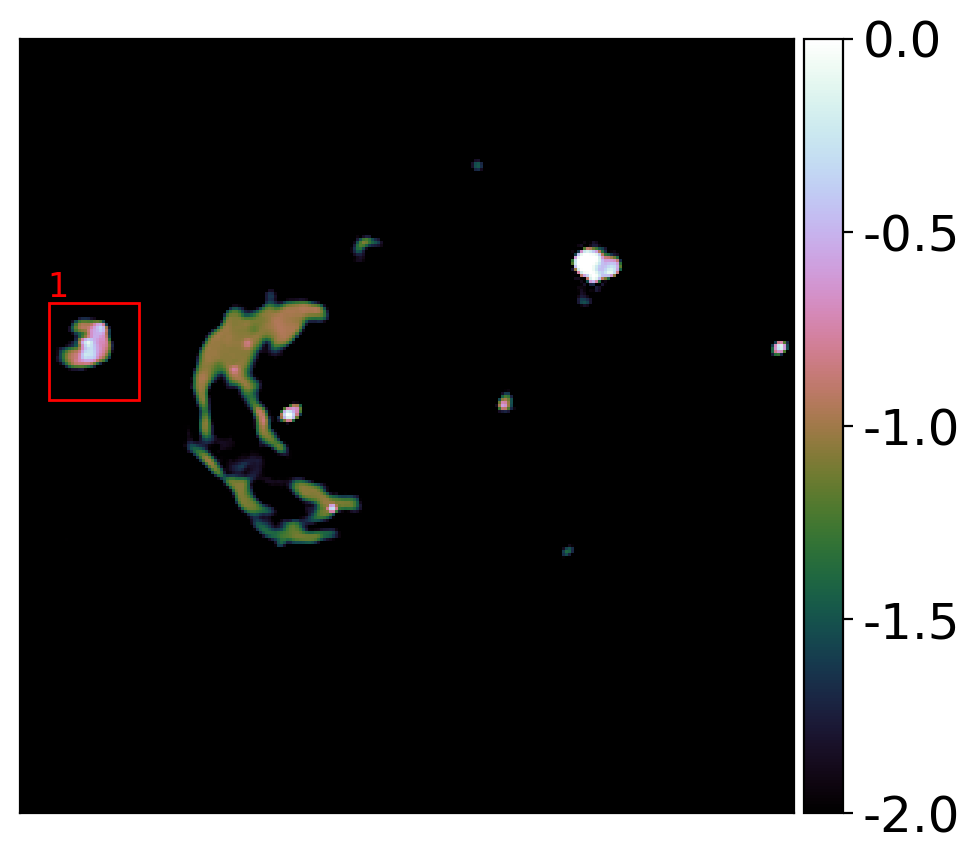

[GD] 0 out of 15000 iterations, tol = 0.000117
[GD] converged in 77 iterations


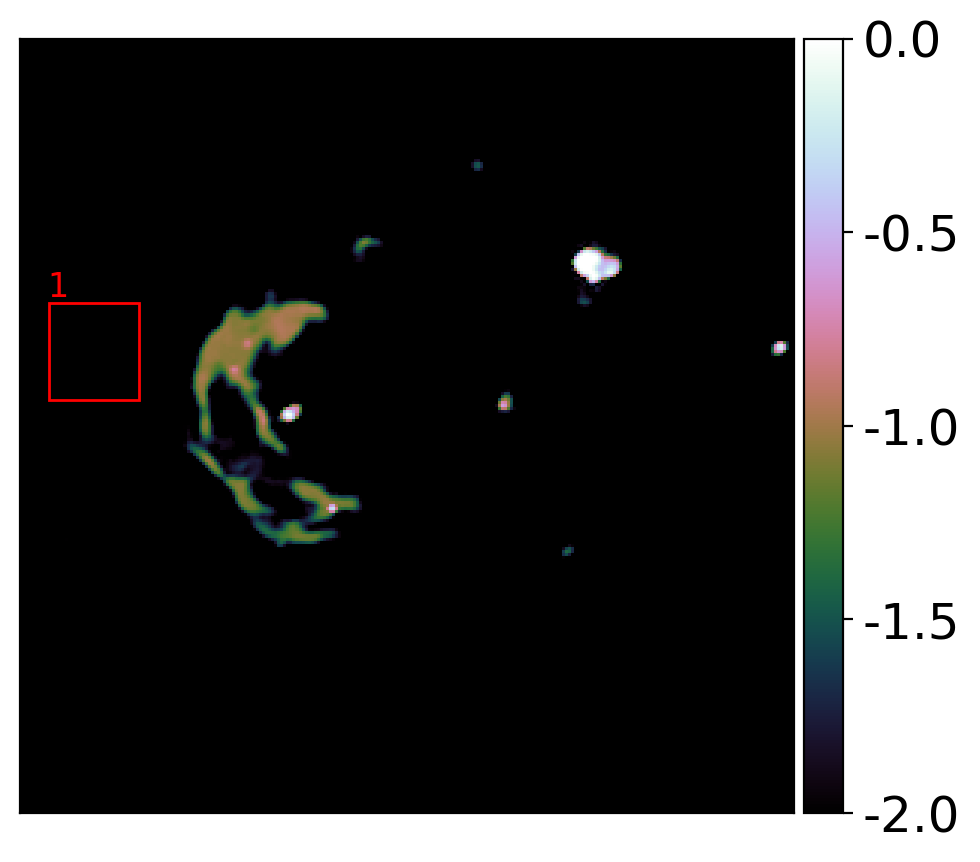

gamma_alpha:  87574.92908368903
fun(x_mmse).item():  22151.998046875
tau_alpha*np.sqrt(N) + N:  67981.57752118903
W28 _gamma_alpha(samples):  61158.92171875
W28 : Inpainted area nonremovable! (Reject H0)
W28 _gamma_alpha:  87574.92908368903
W28 _potential:  464876.25
W28 -MMSE_potential:  22151.998046875
W28 : Blurred structure is physical! (Reject H0)
W28 _gamma_alpha:  87574.92908368903
W28 _potential_blurring:  838725.4375
W28 -MMSE_potential:  22151.998046875


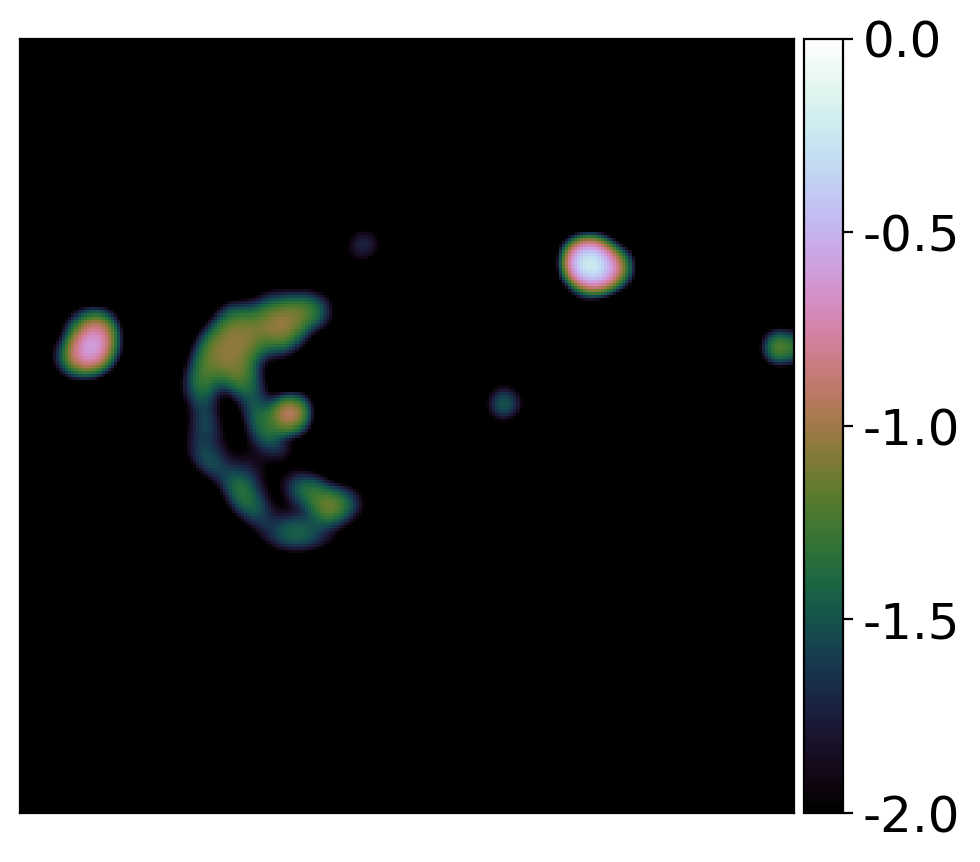

In [3]:

for it_img in range(len(img_name_list)):

    img_name = img_name_list[it_img]
    map_vars_path = map_vars_path_arr[it_img]
    samp_vars_path = samp_vars_path_arr[it_img]
    vmin_log = vmin_log_arr[it_img]
    samp_samples_path = samp_samples_path_arr[it_img]

    text_pos = text_pos_arr[it_img]
    textstr = text_str_arr[it_img]
    saving_text_str = saving_text_str_arr[it_img]

    # Load variables
    map_vars = np.load(map_vars_path, allow_pickle=True)[()]
    samp_vars = np.load(samp_vars_path, allow_pickle=True)[()]
    samples = np.load(samp_samples_path, allow_pickle=True)

    # Load image and mask
    img, mat_mask = luq.helpers.load_imgs(img_name, repo_dir)

    # Define my torch types
    myType = torch.float32
    myComplexType = torch.complex64


    # Aliases
    x = img
    ground_truth = img
    # Prepare inputs and functions
    torch_img = torch.tensor(
        np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape
    )
    phi = luq.operators.MaskedFourier_torch(
        shape=img.shape, 
        ratio=0.5 ,
        mask=mat_mask,
        norm='ortho',
        device=device
    )
    y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

    # Define X Cai noise level
    eff_sigma = luq.helpers.compute_complex_sigma_noise(y, input_snr)
    sigma = eff_sigma * np.sqrt(2)

    # Generate noise
    rng = np.random.default_rng(seed=0)
    n_re = rng.normal(0, eff_sigma, y[y!=0].shape)
    n_im = rng.normal(0, eff_sigma, y[y!=0].shape)
    # Add noise
    y[y!=0] += (n_re + 1.j*n_im)

    # Observation
    torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
    x_init = torch.abs(phi.adj_op(torch_y))

    # %%
    # Define the likelihood
    g = luq.operators.L2Norm_torch(
        sigma=sigma,
        data=torch_y,
        Phi=phi,
    )
    # Lipschitz constant computed automatically by g, stored in g.beta

    # Define real prox
    f = luq.operators.RealProx_torch()


    # Extract variables
    x_gt = samp_vars['X_ground_truth']
    x_dirty = samp_vars['X_dirty']
    x_map = samp_vars['X_MAP']
    x_mmse = samp_vars['X_MMSE']

    # Inpainting
    # Load mask details
    pysiscal = pysiscal_list[it_img]
    mask_x, mask_y = luq.helpers.get_hypothesis_test_mask(img_name, pysiscal)
    # Prepare mask
    np_mask_inpainting = np.zeros((img.shape[0], img.shape[1]))
    np_mask_inpainting[mask_x[0]:mask_x[1], mask_y[0]:mask_y[1]] = 1
    # Prepare inpaint image
    inpaint_img = np.copy(x_mmse)
    inpaint_img[np_mask_inpainting.astype(bool)] = 0


    mask_inpainting = to_tensor(np_mask_inpainting)
    x_init_imp = to_tensor(inpaint_img)

    # Define rectangle coordinates
    rect_anchor_xy = (mask_y[0], mask_x[0])
    rect_width = mask_y[1] - mask_y[0]
    rect_height = mask_x[1] - mask_x[0]
    # Define text attributes
    font = {
        'color':  'red',
        'weight': 'normal',
        'size': 12,
    }

    fig = plt.figure(figsize=(5,5), dpi=200)
    axs = plt.gca()
    plt_im = axs.imshow(np.log10(np.abs(x_mmse)), cmap=cmap, vmin=vmin_log, vmax=0)
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(plt_im, cax=cax)
    cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=cbar_font_size)
    axs.set_yticks([]);axs.set_xticks([])
    plt.tight_layout()
    plt.savefig(
        '{:s}{:s}{:s}{:s}{:s}{:s}'.format(
            save_dir, img_name, model_prefix, '_region_', saving_text_str, '-MMSE_image.pdf'
        ),
        bbox_inches='tight',
        dpi=200
    )
    plt.show()

    fig = plt.figure(figsize=(5,5), dpi=200)
    axs = plt.gca()
    plt_im = axs.imshow(np.log10(np.abs(x_mmse)), cmap=cmap, vmin=vmin_log, vmax=0)
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(plt_im, cax=cax)
    cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=cbar_font_size)
    axs.set_yticks([]);axs.set_xticks([])
    # Create a Rectangle patch
    rect = patches.Rectangle(
        rect_anchor_xy, rect_width, rect_height,
        linewidth=1, edgecolor='r', facecolor='none'
    )
    # Add the patch to the Axes
    axs.add_patch(rect)
    axs.text(
        rect_anchor_xy[0]/x_map.shape[1] + text_pos[0],
        1 - rect_anchor_xy[1]/x_map.shape[0] + text_pos[1],
        textstr, transform=axs.transAxes, 
        fontdict=font, verticalalignment='top'
    )
    plt.tight_layout()
    plt.savefig(
        '{:s}{:s}{:s}{:s}{:s}{:s}'.format(
            save_dir, img_name, model_prefix, '_region_', saving_text_str, '-MMSE_image_inpaintedRegion.pdf'
        ),
        bbox_inches='tight',
        dpi=200
    )
    plt.show()


    # To tensor
    x_mmse_torch = to_tensor(x_mmse)
    x_map_torch = to_tensor(x_map)
    # Compute stepsize
    alpha = 0.98 / (g.beta + mu * lmbd * L_CRR)
    # initialization
    x_hat = torch.clone(x_init_imp)
    z = torch.clone(x_init_imp)
    t = 1

    for it_2 in range(inptaint_options['iter']):
        x_hat_old = torch.clone(x_hat)
        
        # x_hat = z - alpha *(g.grad(z) + lmbd * model(mu * z))
        x_hat = z - alpha *lmbd * model(mu * z)
        # Positivity constraint
        x_hat = f.prox(x_hat)
        # Positivity constraint
        # x = torch.clamp(x, 0, None)

        x_hat = torch.clone(x_hat) * mask_inpainting + torch.clone(x_mmse_torch) * (1. - mask_inpainting)
        
        t_old = t 
        t = 0.5 * (1 + math.sqrt(1 + 4*t**2))
        z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

        # relative change of norm for terminating
        res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()

        if res < inptaint_options['tol']:
            print("[GD] converged in %d iterations"%(it_2))
            break

        if it_2 % inptaint_options['update_iter'] == 0:
            print(
                "[GD] %d out of %d iterations, tol = %f" %(            
                    it_2,
                    inptaint_options['iter'],
                    res,
                )
            )

    x_mmse_torch = to_tensor(x_mmse)

    # Generate surrogate impainted img
    surrogate_img = torch.clone(x_hat) * mask_inpainting + torch.clone(x_mmse_torch) * (1. - mask_inpainting)

    imp_surrogate = to_numpy(torch.clone(surrogate_img))

    # Define rectangle coordinates
    rect_anchor_xy = (mask_y[0], mask_x[0])
    rect_width = mask_y[1] - mask_y[0]
    rect_height = mask_x[1] - mask_x[0]
    # Define text attributes
    font = {
        'color':  'red',
        'weight': 'normal',
        'size': 12,
    }

    fig = plt.figure(figsize=(5,5), dpi=200)
    axs = plt.gca()
    plt_im = axs.imshow(np.log10(np.abs(imp_surrogate)), cmap=cmap, vmin=vmin_log, vmax=0)
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(plt_im, cax=cax)
    cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=cbar_font_size)
    axs.set_yticks([]);axs.set_xticks([])

    # Create a Rectangle patch
    rect = patches.Rectangle(
        rect_anchor_xy, rect_width, rect_height,
        linewidth=1, edgecolor='r', facecolor='none'
    )
    # Add the patch to the Axes
    axs.add_patch(rect)
    axs.text(
        rect_anchor_xy[0]/x_map.shape[1] + text_pos[0],
        1 - rect_anchor_xy[1]/x_map.shape[0] + text_pos[1],
        textstr, transform=axs.transAxes, 
        fontdict=font, verticalalignment='top'
    )
    plt.tight_layout()
    plt.savefig(
        '{:s}{:s}{:s}{:s}{:s}{:s}'.format(
            save_dir, img_name, model_prefix, '_region_', saving_text_str, '-MMSE-inpaintedSurrogate_maskRegion.pdf'
        ),
        bbox_inches='tight',
        dpi=200
    )
    plt.show()


    #function handles for the hypothesis test
    def _fun(_x, model, mu, lmbd):
        return (lmbd / mu) * model.cost(mu * _x) + g.fun(_x)

    def _grad_fun(_x, g, model, mu, lmbd):
        return  torch.real(g.grad(_x) + lmbd * model(mu * _x))

    def _prior_fun(_x, model, mu, lmbd):
        return (lmbd / mu) * model.cost(mu * _x)

    # Evaluation of the potentials
    fun = partial(_fun, model=model, mu=mu, lmbd=lmbd)
    prior_fun = partial(_prior_fun, model=model, mu=mu, lmbd=lmbd)
    # Evaluation of the gradient
    grad_f = partial(_grad_fun, g=g, model=model, mu=mu, lmbd=lmbd)
    # Evaluation of the potential in numpy
    fun_np = lambda _x : fun(luq.utils.to_tensor(_x, dtype=myType)).item()

    # Compute HPD region bound
    N = x_map.size
    tau_alpha = np.sqrt(16*np.log(3/alpha_prob))
    gamma_alpha = fun(x_map_torch).item() + tau_alpha*np.sqrt(N) + N

    print('gamma_alpha: ', gamma_alpha)
    print('fun(x_mmse).item(): ', fun(x_mmse_torch).item())
    print('tau_alpha*np.sqrt(N) + N: ', tau_alpha*np.sqrt(N) + N)

    # Compute sample-based gamma_alpha
    potential_samples = [fun_np(samp) for samp in samples]
    p = np.array([alpha_prob, 1-alpha_prob])
    samp_quantiles = np.quantile(potential_samples, p, axis=0)
    gamma_alpha_samples = samp_quantiles[1]
    print(img_name, '_gamma_alpha(samples): ', samp_quantiles[1])
    
    # Compute potential
    mmse_potential = fun(x_mmse_torch).item()
    potential = fun(surrogate_img).item()

    if potential > gamma_alpha:
        print(img_name, ': Inpainted area nonremovable! (Reject H0)')
        Hnot_reject = True
    else:
        print(img_name, ': Inpainted area removable! (Cannot reject H0)')
        Hnot_reject = False
    # Print values
    print(img_name, '_gamma_alpha: ', gamma_alpha)
    print(img_name, '_potential: ', potential)
    print(img_name, '-MMSE_potential: ', mmse_potential)
    # Save values
    mmse_potential_list.append(mmse_potential)
    surrogate_potential_list.append(potential)
    gamma_alpha_list.append(gamma_alpha)
    gamma_alpha_samples_list.append(gamma_alpha_samples)
    Hnot_reject_list.append(Hnot_reject)


    # Hypothesis test of blurred image
    gauss_blurred_im_np = sp.ndimage.gaussian_filter(
        input=np.copy(x_mmse),
        sigma=G_sigma,
        radius=np.int64(np.floor(2*G_sigma)),
    )
    gauss_blurred_im = to_tensor(gauss_blurred_im_np)


    # Compute potential
    potential_blurring = fun(gauss_blurred_im).item()

    if potential_blurring > gamma_alpha:
        print(img_name, ': Blurred structure is physical! (Reject H0)')
        Hnot_reject_blurring = True
    else:
        print(img_name, ': Cannot conclude if blurred structure is physical! (Cannot reject H0)')
        Hnot_reject_blurring = False
    # Print values
    print(img_name, '_gamma_alpha: ', gamma_alpha)
    print(img_name, '_potential_blurring: ', potential_blurring)
    print(img_name, '-MMSE_potential: ', mmse_potential)
    # Save values
    potential_blurring_list.append(potential_blurring)
    Hnot_reject_blurring_list.append(Hnot_reject_blurring)

    # Plot image
    fig = plt.figure(figsize=(5,5), dpi=200)
    axs = plt.gca()
    plt_im = axs.imshow(np.log10(np.abs(to_numpy(gauss_blurred_im))), cmap=cmap, vmin=vmin_log, vmax=0)
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(plt_im, cax=cax)
    cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=cbar_font_size)
    axs.set_yticks([]);axs.set_xticks([])
    plt.tight_layout()
    plt.savefig(
        '{:s}{:s}{:s}{:s}{:.2f}{:s}'.format(
            save_dir, img_name, model_prefix, '-MMSE-blurred_surrogate_image_Gsigma_', G_sigma, '.pdf'
        ),
        bbox_inches='tight',
        dpi=200
    )
    plt.show()


params_dict = {
    'model_prefix': model_prefix,
    'inptaint_options': inptaint_options,
    'sigma_training': sigma_training,
    't_model': t_model,
    'lmbd': lmbd,
    'mu': mu,
    'G_sigma': G_sigma,
}
save_dict = {
    'params_dict': params_dict,
    'alpha_prob': alpha_prob,
    'mmse_potential_list': mmse_potential_list,
    'surrogate_potential_list': surrogate_potential_list,
    'gamma_alpha_list': gamma_alpha_list,
    'gamma_alpha_samples_list': gamma_alpha_samples_list,
    'Hnot_reject_list': Hnot_reject_list,
    'potential_blurring_list': potential_blurring_list,
    'Hnot_reject_blurring_list': Hnot_reject_blurring_list,
    'map_vars_path_arr': map_vars_path_arr,
    'samp_vars_path_arr': samp_vars_path_arr,
    'img_name_list': img_name_list,
    'pysiscal_list': pysiscal_list,
    'vmin_log_arr': vmin_log_arr,
    'text_str_arr': text_str_arr,
    'text_pos_arr': text_pos_arr,
}

# Save variables
try:
    save_path = '{:s}{:s}{:s}{:s}'.format(
        save_dir, 'hypothesisTest_samples', model_prefix, '_vars.npy'
    )
    if os.path.isfile(save_path):
        os.remove(save_path)
    np.save(save_path, save_dict, allow_pickle=True)

except Exception as e:
    print('Could not save vairables. Exception caught: ', e)




In [4]:
hyp_test_path = save_dir + 'hypothesisTest_samples-CRR_vars.npy'
# hyp_test_path = save_path
hyp_test_res = np.load(hyp_test_path, allow_pickle=True)[()]

# print(hyp_test_res.keys())

for it in range(len(hyp_test_res['img_name_list'])):

    print('img: ', hyp_test_res['img_name_list'][it])
    print('Hypothesis test: Blurring')
    print('Threshold: \t\t', hyp_test_res['gamma_alpha_list'][it])
    print('Threshold(samples): \t\t', hyp_test_res['gamma_alpha_samples_list'][it])
    print('MMSE potential: \t\t', hyp_test_res['mmse_potential_list'][it])
    print('Blurring potential: \t', hyp_test_res['potential_blurring_list'][it])
    print('H0 reject: \t\t', hyp_test_res['Hnot_reject_blurring_list'][it])
    print(' ')
    print('Hypothesis test: Inpainting')
    print('Threshold: \t\t', hyp_test_res['gamma_alpha_list'][it])
    print('Threshold(samples): \t\t', hyp_test_res['gamma_alpha_samples_list'][it])
    print('MMSE potential: \t\t', hyp_test_res['mmse_potential_list'][it])
    print('Surrogate potential: \t', hyp_test_res['surrogate_potential_list'][it])
    print('H0 reject: \t\t', hyp_test_res['Hnot_reject_list'][it])
    print('\n')


img:  CYN
Hypothesis test: Blurring
Threshold: 		 145029.31792173782
Threshold(samples): 		 84771.47109375
MMSE potential: 		 12532.802734375
Blurring potential: 	 964157.875
H0 reject: 		 True
 
Hypothesis test: Inpainting
Threshold: 		 145029.31792173782
Threshold(samples): 		 84771.47109375
MMSE potential: 		 12532.802734375
Surrogate potential: 	 18197.3984375
H0 reject: 		 False


img:  M31
Hypothesis test: Blurring
Threshold: 		 98991.88416181403
Threshold(samples): 		 74248.54484375
MMSE potential: 		 33950.5234375
Blurring potential: 	 190539.984375
H0 reject: 		 True
 
Hypothesis test: Inpainting
Threshold: 		 98991.88416181403
Threshold(samples): 		 74248.54484375
MMSE potential: 		 33950.5234375
Surrogate potential: 	 67508.203125
H0 reject: 		 False


img:  3c288
Hypothesis test: Blurring
Threshold: 		 90839.30017743903
Threshold(samples): 		 65872.4159375
MMSE potential: 		 25658.501953125
Blurring potential: 	 92047.96875
H0 reject: 		 True
 
Hypothesis test: Inpainting
T